# Import Important libs

In [87]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.stem import SnowballStemmer,  WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
import re
from textblob import TextBlob, Word
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.chunk import ne_chunk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alhasan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alhasan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alhasan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alhasan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/alhasan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/alhasan/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /Users/alhasan/nltk_data...
[nltk_data]   Package words is al

# Loading Data and Overview

In [88]:
df_twitter = pd.read_csv("./Sentiment analysis/Twitter_Data.csv", sep=",")
df_reddit = pd.read_csv("./Sentiment analysis/Reddit_Data.csv", sep=",")

In [89]:
df_reddit = df_reddit.rename(columns={'clean_comment': 'clean_text'})

In [90]:
df = pd.concat([df_twitter, df_reddit], ignore_index=True)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [91]:
df.isna().sum()

clean_text    104
category        7
dtype: int64

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200229 entries, 0 to 200228
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  200125 non-null  object 
 1   category    200222 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


## Handling Nulls


In [93]:
df['category'] = df['category'].fillna(0)
df['clean_text'] = df['clean_text'].fillna('')

## Applying Regex to remove symbols and stuff like that

In [94]:
comments = df['clean_text'].tolist()
comments = [
    ' '.join(re.findall(r'\b[a-zA-Z]+\b', comment))
    for comment in comments
]

# Tokenization

In [95]:
tokenized_comments = [word_tokenize(comment) for comment in comments]
print(tokenized_comments[0])

['when', 'modi', 'promised', 'minimum', 'government', 'maximum', 'governance', 'expected', 'him', 'begin', 'the', 'difficult', 'job', 'reforming', 'the', 'state', 'why', 'does', 'take', 'years', 'get', 'justice', 'state', 'should', 'and', 'not', 'business', 'and', 'should', 'exit', 'psus', 'and', 'temples']


In [96]:
lemmatizer = WordNetLemmatizer()

pos_tagged_comments = [pos_tag(comment) for comment in tokenized_comments]

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
    
lemmatized_comments = [
    [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in comment] for comment in pos_tagged_comments
] 

print(lemmatized_comments[0])

['when', 'modi', 'promise', 'minimum', 'government', 'maximum', 'governance', 'expect', 'him', 'begin', 'the', 'difficult', 'job', 'reform', 'the', 'state', 'why', 'do', 'take', 'year', 'get', 'justice', 'state', 'should', 'and', 'not', 'business', 'and', 'should', 'exit', 'psus', 'and', 'temple']


# Removing Stop words

In [97]:
stop_words = stopwords.words("english")

In [98]:
filtered_comments = [[word for word in comment if word not in stop_words] for comment in lemmatized_comments]
print(filtered_comments[0])

['modi', 'promise', 'minimum', 'government', 'maximum', 'governance', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justice', 'state', 'business', 'exit', 'psus', 'temple']


In [99]:
rejoined_comments = [' '.join(word) for word in filtered_comments]
print(rejoined_comments[0])

modi promise minimum government maximum governance expect begin difficult job reform state take year get justice state business exit psus temple


# Applying TF-IDF

In [100]:
tf_idf_vectorizer = TfidfVectorizer(max_features= 10000)
X = tf_idf_vectorizer.fit_transform(rejoined_comments)

In [101]:
feature_names = tf_idf_vectorizer.get_feature_names_out()

In [102]:
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)  # type: ignore
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (200229, 10000)


In [103]:
joblib.dump(tf_idf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# **Modeling**

### Splitting

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category'].tolist(), test_size= 0.2, random_state= 42)

### Importing Models and evaluation metrics

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [106]:
lr = LogisticRegression()
nb = MultinomialNB()
svm = LinearSVC()
rf = RandomForestClassifier()

#### Logistic Regression

Test Set Evaluation:
Accuracy: 0.8603855566098986
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.73      0.78      8699
     Neutral       0.84      0.94      0.88     13713
    Positive       0.89      0.86      0.88     17634

    accuracy                           0.86     40046
   macro avg       0.86      0.84      0.85     40046
weighted avg       0.86      0.86      0.86     40046

Train Set Evaluation:
Accuracy: 0.8780270066111885


/Users/alhasan/.pyenv/versions/3.12.11/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


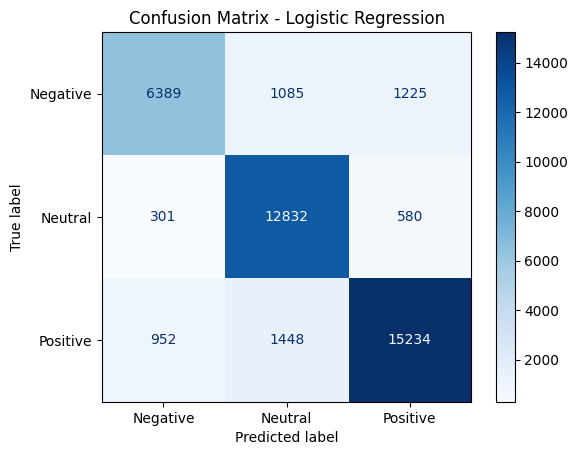

In [107]:
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_lr))
print("Classification Report:")
print(classification_report(y_test, y_lr, target_names=['Negative','Neutral', 'Positive']))

# Train acc
train_acc_lr = lr.score(X_train, y_train)
print("Train Set Evaluation:")
print("Accuracy:", train_acc_lr)

cm = confusion_matrix(y_test, y_lr)
display_lr = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
display_lr.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Best parameters: {'C': 1, 'penalty': 'l1'}
accuracy_score:  0.8737951355940669


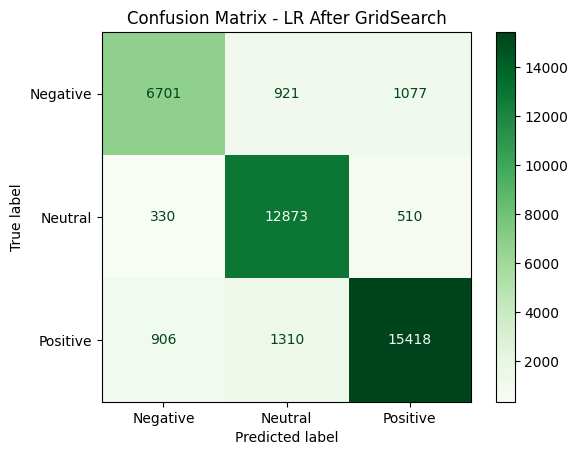

In [108]:
param_grid = {'C': [0.001, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

best_model_lr = grid.best_estimator_
y_pred_tuned = best_model_lr.predict(X_test)
print("accuracy_score: ", accuracy_score(y_pred_tuned, y_test))

# confusion matrix after GridSearch
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(
    confusion_matrix=cm_tuned, display_labels=['Negative', 'Neutral', 'Positive'])
disp_tuned.plot(cmap='Greens')
plt.title("Confusion Matrix - LR After GridSearch")
plt.show()

#### Naive Bayes Classifier

Test Set Evaluation:
Accuracy: 0.6837886430604805
Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.38      0.52      8699
     Neutral       0.78      0.60      0.68     13713
    Positive       0.62      0.90      0.74     17634

    accuracy                           0.68     40046
   macro avg       0.75      0.63      0.64     40046
weighted avg       0.72      0.68      0.67     40046

Train Set Evaluation:
Accuracy: 0.7163057253266576


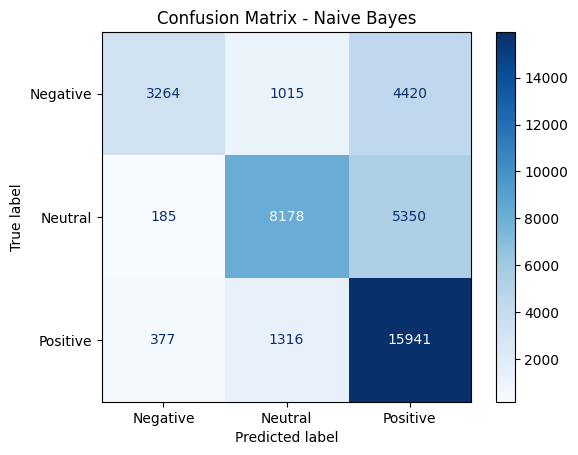

In [109]:
nb.fit(X_train, y_train)
y_nb = nb.predict(X_test)

print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_nb))
print("Classification Report:")
print(classification_report(y_test, y_nb, target_names=['Negative','Neutral', 'Positive']))

# Train acc
train_acc_nb = nb.score(X_train, y_train)
print("Train Set Evaluation:")
print("Accuracy:", train_acc_nb)

cm = confusion_matrix(y_test, y_nb)
display_nb = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
display_nb.plot(cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

#### SVM

Test Set Evaluation:
Accuracy: 0.8695250461968735
Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.77      0.80      8699
     Neutral       0.86      0.93      0.89     13713
    Positive       0.90      0.87      0.88     17634

    accuracy                           0.87     40046
   macro avg       0.86      0.86      0.86     40046
weighted avg       0.87      0.87      0.87     40046

Train Set Evaluation:
Accuracy: 0.893284555789316


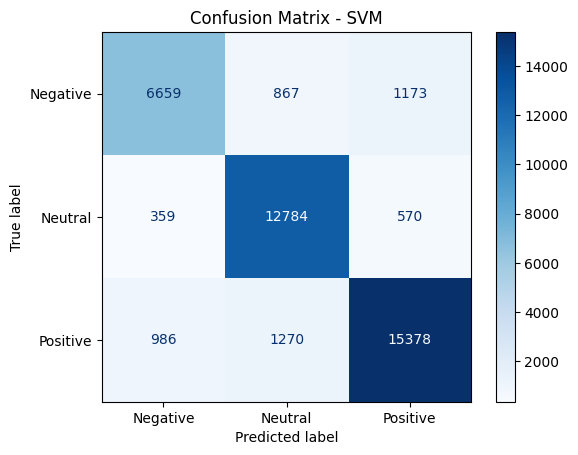

In [110]:
svm.fit(X_train, y_train)
y_svm = svm.predict(X_test)

print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_svm))
print("Classification Report:")
print(classification_report(y_test, y_svm, target_names=['Negative','Neutral', 'Positive']))

# Train acc
train_acc_svm = svm.score(X_train, y_train)
print("Train Set Evaluation:")
print("Accuracy:", train_acc_svm)

cm = confusion_matrix(y_test, y_svm)
display_svm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
display_svm.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()

Best parameters (Linear SVM): {'C': 1}
Linear SVM Test Accuracy (After Tuning): 0.8695250461968735
Linear SVM Train Accuracy (After Tuning): 0.893284555789316


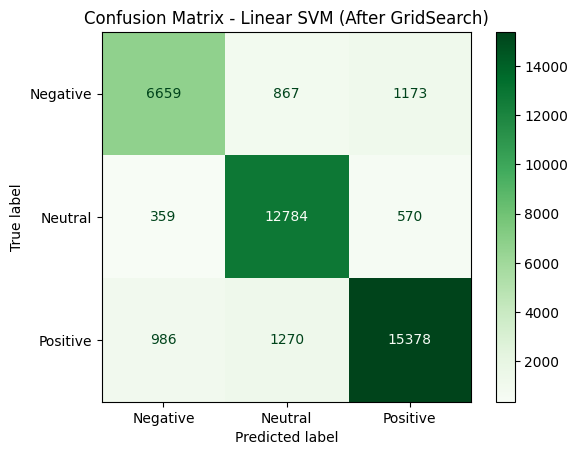

In [111]:
param_grid_svm =  {
    'C': [0.01, 0.1, 1, 10]
}
grid_svm = GridSearchCV(LinearSVC(max_iter=50000), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
print("Best parameters (Linear SVM):", grid_svm.best_params_)

best_svm = grid_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)

print("Linear SVM Test Accuracy (After Tuning):",
      accuracy_score(y_test, y_pred_best_svm))
print("Linear SVM Train Accuracy (After Tuning):",
      best_svm.score(X_train, y_train))

# confusion matrix
cm_svm_after = confusion_matrix(y_test, y_pred_best_svm)
disp_svm_after = ConfusionMatrixDisplay(confusion_matrix=cm_svm_after, display_labels=['Negative', 'Neutral', 'Positive'])
disp_svm_after.plot(cmap="Greens")
plt.title("Confusion Matrix - Linear SVM (After GridSearch)")
plt.show()

#### RandomForest Classifier

Test Set Evaluation:
Accuracy: 0.820156819657394
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.59      0.69      8699
     Neutral       0.82      0.89      0.86     13713
    Positive       0.81      0.88      0.84     17634

    accuracy                           0.82     40046
   macro avg       0.83      0.79      0.80     40046
weighted avg       0.82      0.82      0.82     40046

Train Set Evaluation:
Accuracy: 0.998919985266851


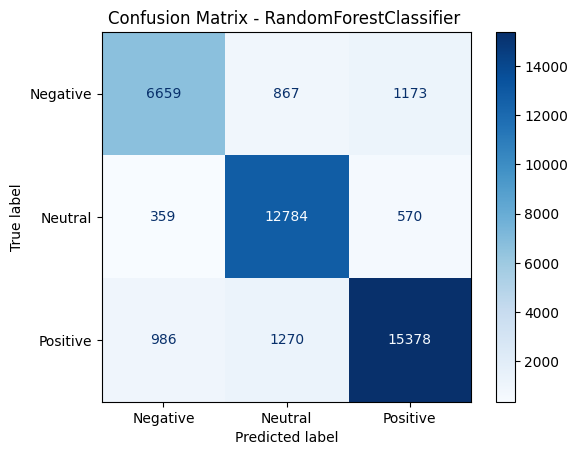

In [112]:
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_rf))
print("Classification Report:")
print(classification_report(y_test, y_rf, target_names=['Negative','Neutral', 'Positive']))

# Train acc
train_acc_rf = rf.score(X_train, y_train)
print("Train Set Evaluation:")
print("Accuracy:", train_acc_rf)

cm = confusion_matrix(y_test, y_svm)
display_rf = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
display_rf.plot(cmap='Blues')
plt.title("Confusion Matrix - RandomForestClassifier ")
plt.show()

## Best Model to save

In [113]:
joblib.dump(best_model_lr, "model.pkl")

['model.pkl']